In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataUtils.CustomDataset as CastomDataset

In [2]:
workers = 2
btch_sz = 16
num_epochs = 10
lr = 0.002
beta1 = 0.5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Training data

240 (1365, 2048, 3) [0 0 1 0]
241 (1365, 2048, 3) [0 0 1 0]
242 (1365, 2048, 3) [0 0 0 1]
243 (1365, 2048, 3) [0 0 0 1]
244 (1365, 2048, 3) [0 0 1 0]
245 (2048, 1365, 3) [0 1 0 0]
246 (1365, 2048, 3) [1 0 0 0]
247 (1365, 2048, 3) [1 0 0 0]
248 (1365, 2048, 3) [1 0 0 0]
249 (1365, 2048, 3) [1 0 0 0]
250 (1365, 2048, 3) [0 0 0 1]
251 (1365, 2048, 3) [0 0 0 1]


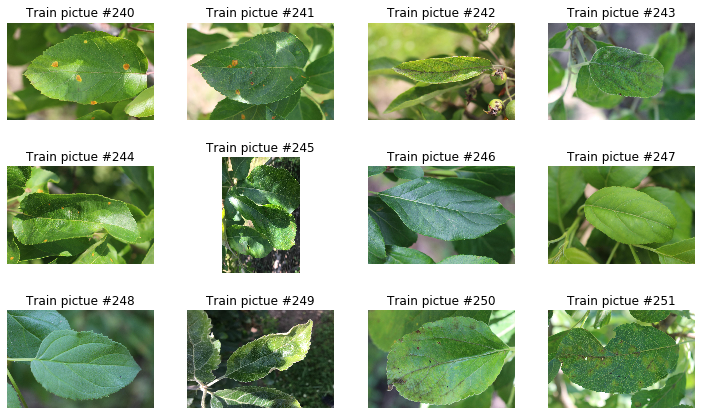

In [4]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv', 'images')

plt.figure(figsize=(10,10))
for i in range(240,252):
    sample = plant_dataset[i]
    print(i, sample['image'].shape, sample['labels'])
    
    ax = plt.subplot(5, 4, i-239)
    plt.tight_layout()
    ax.set_title('Train pictue #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
   

# Format dataloader

In [6]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv',
                                                    'images',
                                                    transform=CastomDataset.ToTensor()
                                                   )

dataloader = DataLoader(plant_dataset, batch_size=btch_sz,
                        shuffle=False, num_workers=workers)

In [7]:
batch = next(iter(dataloader))
batch['image'].shape, batch['labels'].shape

(torch.Size([16, 3, 1365, 2048]), torch.Size([16, 4]))

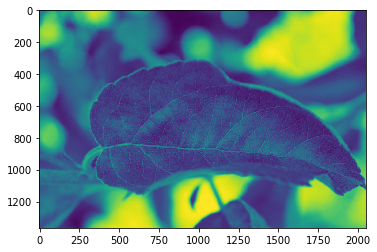

tensor([1, 0, 0, 0])


In [8]:
plt.imshow(batch['image'][2].sum(axis=0))
plt.show()
print(batch['labels'][2])

In [9]:
image = plant_dataset[245]['image']
image.shape

torch.Size([3, 1365, 2048])

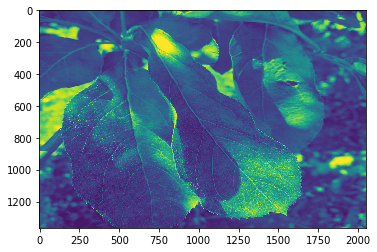

In [12]:
plt.imshow(image.sum(axis=0))
plt.show()

# Training loop

In [23]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        btch_sz = len(batch['image'])
        if i%5 == 0:
            print('[{}/{}][{}/{}]'.format(epoch, num_epochs, i*btch_sz, btch_sz*len(dataloader)))
    break

[0/10][0/1824]
[0/10][80/1824]
[0/10][160/1824]
[0/10][240/1824]
[0/10][320/1824]
[0/10][400/1824]
[0/10][480/1824]
[0/10][560/1824]
[0/10][640/1824]
[0/10][720/1824]
[0/10][800/1824]
[0/10][880/1824]
[0/10][960/1824]
[0/10][1040/1824]
[0/10][1120/1824]
[0/10][1200/1824]
[0/10][1280/1824]
[0/10][1360/1824]
[0/10][1440/1824]
[0/10][1520/1824]
[0/10][1600/1824]
[0/10][1680/1824]
[0/10][1760/1824]
